<a href="https://colab.research.google.com/github/sh20022002/probability_of_change/blob/main/trader_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [176]:
import numpy as np
import pandas as pd
import yfinance as yf

from sklearn.preprocessing import StandardScaler
import pickle
import os
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim
import random
import collections


In [177]:

MODEL_SAVE_PATH = "dqn_trading_model.pth"
SP500_TICKERS = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"


class StockDataset:
    def __init__(self, tickers, num_segments=10):
        self.tickers = tickers
        self.num_segments = num_segments  # Number of parts to divide the dataset into
        self.segmented_data = []  # Preprocessed data
        self.current_ticker_idx = 0  # Keep track of which stock is being processed

        self._load_and_split_data()

    def _load_and_split_data(self):
      """Loads full dataset once and splits into shuffled segments"""
      scaler_saved = False  # Only save once

      for ticker in self.tickers:
          stock_data = yf.download(ticker, period='max', progress=False)
          if stock_data.empty:
              continue

          # Convert to DataFrame and preprocess
          df = stock_data[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
          df['Return'] = df['Close'].pct_change()
          df['SMA150'] = df['Close'].rolling(window=150).mean()
          df.dropna(inplace=True)

          features = df[['Open', 'Close', 'Return', 'Volume', 'SMA150']]
          scaler = StandardScaler().fit(features)

          #  Save scaler ONCE if not already saved
          if not scaler_saved:
              os.makedirs("data", exist_ok=True)
              with open("data/scaler.pkl", "wb") as f:
                  pickle.dump(scaler, f)
              print(f" Scaler saved using {ticker}")
              scaler_saved = True

          scaled_values = scaler.transform(features).astype(np.float32)
          segment_size = len(scaled_values) // self.num_segments
          segments = [scaled_values[i * segment_size:(i + 1) * segment_size] for i in range(self.num_segments)]
          self.segmented_data.extend([(segment, ticker) for segment in segments])

      random.shuffle(self.segmented_data)


    def fetch_next_stock(self):
        """Returns a dataset segment in order, keeping track of stock index."""
        if not self.segmented_data:
            return None, None  # No more stocks

        if self.current_ticker_idx >= len(self.segmented_data):
            self.current_ticker_idx = 0  # Loop back to start

        segment, ticker = self.segmented_data[self.current_ticker_idx]
        self.current_ticker_idx += 1
        return segment, ticker

    def save(self, path):
        """
        Saves the StockDataset to a pickle file.

        Args:
            filepath (str): The path to the pickle file.
        """
        os.makedirs(os.path.dirname(path), exist_ok=True)
        with open(path, 'wb') as f:
            pickle.dump(self, f)
        print('Saved Dataset.')

    @staticmethod
    def load(path):
        """
        Loads the StockDataset from a pickle file.

        Args:
            filepath (str): The path to the pickle file.

        Returns:
            StockDataset: The loaded StockDataset object.
        """
        with open(path, 'rb') as f:
            return pickle.load(f)




In [178]:

# Cell 2: Preprocess Data
def preprocess_data(df):
    """Preprocesses stock data by adding features and scaling."""
    df['Return'] = df['Close'].pct_change()
    df['SMA150'] = df['Close'].rolling(window=150).mean()
    df.dropna(inplace=True)

    # Select features to scale
    features = df[['Open', 'Close', 'Return', 'Volume', 'SMA150']]
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(features)

    # Save the fitted scaler

    os.makedirs("data", exist_ok=True)
    with open("data/scaler.pkl", "wb") as f:
        pickle.dump(scaler, f)

    return scaled_data, scaler

In [179]:
class TradingEnv(gym.Env):
    def __init__(self, data, trading_mode='both', transaction_fee=5):
        super(TradingEnv, self).__init__()
        self.data = data
        self.trading_mode = trading_mode  # 'long', 'short', or 'both'
        self.transaction_fee = transaction_fee
        self.current_step = 0
        self.cash = 10000
        self.position = 0
        self.short_position = 0
        self.done = False
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(5,), dtype=np.float32)
        with open("data/scaler.pkl", "rb") as f:
            self.scaler = pickle.load(f)
        self.prev_value = self.cash  # Track portfolio value for delta rewards


    def reset(self):
      self.current_step = 0
      self.cash = 10000
      self.position = 0
      self.short_position = 0
      self.done = False
      self.prev_value = self.cash  # Track portfolio value for delta rewards
      return self._get_observation()


    def _get_observation(self):
        """Ensure proper extraction of scalar values to avoid deprecation warnings."""
        if self.current_step >= len(self.data):
            self.current_step = len(self.data) - 1
        # In _get_observation():
        raw_obs = np.concatenate((self.data[self.current_step], np.array([self.position, self.cash], dtype=np.float32)))

        # Split: scale only first 5
        features = raw_obs[:5].reshape(1, -1)
        others = raw_obs[5:]
        columns = ['Open', 'Close', 'Return', 'Volume', 'SMA150']
        features_df = pd.DataFrame(features, columns=columns)
        scaled = self.scaler.transform(features_df)[0]
        scaled_obs = np.concatenate((scaled, others))

        return scaled_obs


    def step(self, action):
        current_price = self.data[self.current_step][3]  # Close price

        if action == 1 and self.trading_mode in ['long', 'both']:  # Buy
            shares_to_buy = self.cash // current_price
            self.cash -= shares_to_buy * current_price + self.transaction_fee
            self.position += shares_to_buy

        elif action == 2 and self.trading_mode in ['short', 'both']:  # Short sell
            shares_to_short = self.cash // current_price
            self.cash += shares_to_short * current_price - self.transaction_fee
            self.short_position += shares_to_short

        elif action == 2 and self.position > 0:  # Sell long position
            self.cash += self.position * current_price - self.transaction_fee
            self.position = 0

        elif action == 1 and self.short_position > 0:  # Cover short position
            self.cash -= self.short_position * current_price + self.transaction_fee
            self.short_position = 0

        price = self.data[self.current_step][3]
        new_value = self.cash + (self.position - self.short_position) * price
        reward = new_value - self.prev_value
        self.prev_value = new_value
        reward = np.clip(reward, -100, 100)

        self.current_step += 1

        self.prev_value = new_value
        reward = np.clip(reward, -100, 100)

        if self.current_step >= len(self.data) - 1:
            self.done = True

        return self._get_observation(), reward, self.done, {}



In [180]:
def evaluate_model(stock_data, model):
    """Evaluates the model on stock data and returns total reward."""
    env = TradingEnv(stock_data)
    state = env.reset()
    done = False
    total_reward = 0
    actions = []

    while not done:
        with torch.no_grad():
            q_values = model(torch.tensor(state, dtype=torch.float32).unsqueeze(0))
            action = torch.argmax(q_values).item()

        actions.append(action)
        state, reward, done, _ = env.step(action)
        total_reward += reward

    return total_reward, actions

# Function to plot evaluation results
def plot_evaluation_results(stock_data, actions):
    """Plots stock data and overlays model evaluation results."""
    close_prices = stock_data[:, 3]  # Close prices

    plt.figure(figsize=(12, 6))
    plt.plot(close_prices, label="Close Price", color='black')

    buy_signals = [i for i in range(len(actions)) if actions[i] == 1]
    sell_signals = [i for i in range(len(actions)) if actions[i] == 2]

    plt.scatter(buy_signals, close_prices[buy_signals], color='green', marker='^', label='Buy')
    plt.scatter(sell_signals, close_prices[sell_signals], color='red', marker='v', label='Sell')

    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.title(f"Model Evaluation Results")
    plt.show()



In [181]:
def init_or_load(input_dim: int = 7,
                     output_dim: int = 3,
                     lr: float = 1e-3,
                     memory_size: int = 10_000):
    """
    Returns (model, optimizer, memory), loading pretrained weights if available.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    model = StockLSTM(input_dim=input_dim, output_dim=output_dim).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    memory = collections.deque(maxlen=memory_size)

    if os.path.exists(MODEL_SAVE_PATH):
        model.load_state_dict(torch.load(MODEL_SAVE_PATH))
        print(f" Loaded existing model from {MODEL_SAVE_PATH}")
    else:
        print("  No existing model found — initialized new network.")

    return model, optimizer, memory, device

In [182]:

if os.path.exists("data/stock_dataset.pkl"):
    dataset = StockDataset.load("data/stock_dataset.pkl")
else:
    tickers = pd.read_html(SP500_TICKERS)[0]['Symbol'].tolist()
    dataset = StockDataset(tickers, num_segments=10)
    dataset.save("data/stock_dataset.pkl")


In [ ]:
class StockLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=3, output_dim=3):
      super().__init__()
      self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.3)
      self.norm = nn.LayerNorm(hidden_dim)
      self.dropout = nn.Dropout(0.3)
      self.fc1 = nn.Linear(hidden_dim, hidden_dim // 2)
      self.fc2 = nn.Linear(hidden_dim // 2, output_dim)

    def forward(self, x):
      x = x.to(next(self.parameters()).device)
      _, (h_n, _) = self.lstm(x)
      x = h_n[-1]
      x = self.norm(x)
      x = self.dropout(x)
      x = torch.relu(self.fc1(x))
      return self.fc2(x)


# Train the RL agent using StockDataset
def train_on_sp500(detaset, episodes=10, batch_size=64, gamma=0.95, lr=0.001, save_interval=30):

    # if os.path.exists(MODEL_SAVE_PATH):
    #   os.remove(MODEL_SAVE_PATH)
    #   print(" Removed incompatible model weights.")
    model, optimizer, memory, device = init_or_load(input_dim=7, output_dim=3, lr=lr)

    # Load existing model if available
    if os.path.exists(MODEL_SAVE_PATH):
        model.load_state_dict(torch.load(MODEL_SAVE_PATH))
        print("Loaded existing model.")

    while True:  # Keep training as long as there are segments

        stock_data, ticker = dataset.fetch_next_stock()
        if stock_data is None:
            print("All data segments processed, restarting training loop...")
            break  # Exit training loop if all data is processed

        env = TradingEnv(stock_data)
        wins = 0

        action_counter = collections.Counter()
        for episode in range(episodes):
            state = env.reset()
            action_counter.clear()
            done = False
            total_reward = 0
            PROFIT = 0
            tax_credit = 0


            while not done:
                exploration_rate = max(0.05, 1.0 - episode / episodes)
                if random.random() < exploration_rate:

                    action = env.action_space.sample()
                else:
                    with torch.no_grad():
                      q_values = model(torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0))
                      # print("Q-values:", q_values.cpu().numpy())  # Debug Q-values
                      action = torch.argmax(q_values).item()

                    action_counter[action] += 1

                next_state, reward, done, _ = env.step(action)
                memory.append((state, action, reward, next_state, done))

                # Sample from replay buffer and update model
                if len(memory) >= batch_size:
                    batch = random.sample(memory, batch_size)
                    states, actions, rewards, next_states, dones = zip(*batch)

                    states = torch.tensor(states, dtype=torch.float32).to(device)
                    actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device)
                    rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device)
                    next_states = torch.tensor(next_states, dtype=torch.float32).to(device)
                    dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(device)

                    q_values = model(states).gather(1, actions)
                    with torch.no_grad():
                        next_q_values = model(next_states).max(1)[0].unsqueeze(1)
                        targets = rewards + gamma * next_q_values * (1 - dones)

                    loss = criterion(q_values, targets)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()


            print("Action counts this episode:", dict(action_counter))

            portfolio_end = env.cash + (env.position - env.short_position) * env.data[env.current_step][3]
            net_profit = portfolio_end - 10000

            if net_profit > 0:
                wins += 1
                tax_liability = 0.25 * net_profit
                tax_due = max(tax_liability - tax_credit, 0)
                tax_credit = max(tax_credit - tax_liability, 0)
            else:
                tax_due = 0
                tax_credit += abs(net_profit) * 0.25

            net_profit_after_tax = net_profit - tax_due
            PROFIT += net_profit_after_tax

            print(f"Ticker: {ticker} | Episode {episode+1}/{episodes} | Net PnL: {net_profit:.2f} | Wins: {wins}/{episode+1}")


            if episode % save_interval == 0:
                torch.save(model.state_dict(), MODEL_SAVE_PATH)
                print("Model progress saved.")

        # Evaluate model after training and plot results

        total_reward, actions = evaluate_model(stock_data, model)
        plot_evaluation_results(stock_data, actions)

    print("Training complete.")
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print("Final model saved.")


In [184]:
if os.path.exists("data/stock_dataset.pkl"):
    dataset = StockDataset.load("data/stock_dataset.pkl")

    #  Fallback: generate scaler if missing
    if not os.path.exists("data/scaler.pkl"):
        print(" scaler.pkl missing — regenerating from dataset")
        for segment, _ in dataset.segmented_data:
            try:
                df = pd.DataFrame(segment, columns=["Open", "Close", "Return", "Volume", "SMA150"])
                scaler = StandardScaler().fit(df)
                os.makedirs("data", exist_ok=True)
                with open("data/scaler.pkl", "wb") as f:
                    pickle.dump(scaler, f)
                print(" Re-saved scaler.")
                break
            except Exception as e:
                print(" Failed to regenerate scaler from segment:", e)

else:
    tickers = pd.read_html(SP500_TICKERS)[0]['Symbol'].tolist()
    dataset = StockDataset(tickers, num_segments=10)
    dataset.save("data/stock_dataset.pkl")


Using device: cuda
 Loaded existing model from dqn_trading_model.pth
Loaded existing model.
Action counts this episode: {}
Ticker: GM | Episode 1/10 | Net PnL: -2411.29 | Wins: 0/1
Model progress saved.
Action counts this episode: {2: 17, 0: 6}
Ticker: GM | Episode 2/10 | Net PnL: -2443.12 | Wins: 0/2
Action counts this episode: {2: 55, 0: 15}
Ticker: GM | Episode 3/10 | Net PnL: -2807.18 | Wins: 0/3
Action counts this episode: {2: 57, 0: 20, 1: 27}
Ticker: GM | Episode 4/10 | Net PnL: -2576.98 | Wins: 0/4
Action counts this episode: {2: 58, 1: 73, 0: 15}
Ticker: GM | Episode 5/10 | Net PnL: -2579.46 | Wins: 0/5
Action counts this episode: {0: 101, 2: 70}
Ticker: GM | Episode 6/10 | Net PnL: -15322.29 | Wins: 0/6
Action counts this episode: {0: 215}
Ticker: GM | Episode 7/10 | Net PnL: -1692.32 | Wins: 0/7
Action counts this episode: {0: 236}
Ticker: GM | Episode 8/10 | Net PnL: -1848.51 | Wins: 0/8
Action counts this episode: {0: 281, 1: 15}
Ticker: GM | Episode 9/10 | Net PnL: -1532.

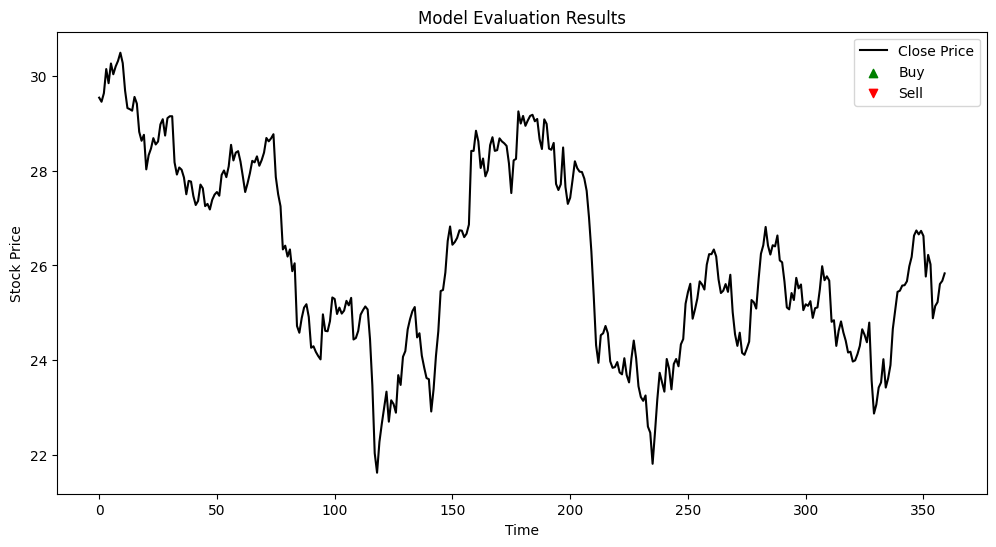

Action counts this episode: {}
Ticker: COP | Episode 1/10 | Net PnL: -3875.13 | Wins: 0/1
Model progress saved.
Action counts this episode: {0: 110, 2: 3}
Ticker: COP | Episode 2/10 | Net PnL: -3794.28 | Wins: 0/2
Action counts this episode: {0: 207, 2: 3, 1: 1}
Ticker: COP | Episode 3/10 | Net PnL: -3788.07 | Wins: 0/3
Action counts this episode: {0: 275, 2: 25}
Ticker: COP | Episode 4/10 | Net PnL: -3332.11 | Wins: 0/4
Action counts this episode: {0: 331, 2: 97}
Ticker: COP | Episode 5/10 | Net PnL: -3987.36 | Wins: 0/5
Action counts this episode: {0: 519, 2: 16}
Ticker: COP | Episode 6/10 | Net PnL: -22468.45 | Wins: 0/6
Action counts this episode: {0: 575, 2: 96}
Ticker: COP | Episode 7/10 | Net PnL: -1477.61 | Wins: 0/7
Action counts this episode: {0: 695, 2: 75}
Ticker: COP | Episode 8/10 | Net PnL: -65937.56 | Wins: 0/8
Action counts this episode: {0: 595, 2: 277}
Ticker: COP | Episode 9/10 | Net PnL: -3870141952.00 | Wins: 0/9
Action counts this episode: {2: 325, 0: 651}
Ticker

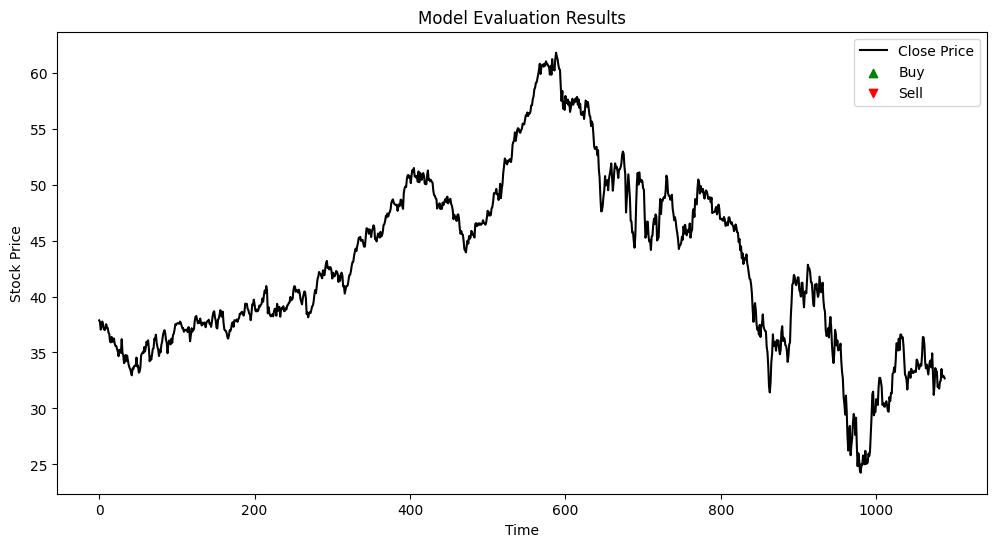

Action counts this episode: {}
Ticker: ADM | Episode 1/10 | Net PnL: -7318.57 | Wins: 0/1
Model progress saved.
Action counts this episode: {0: 90, 2: 18}
Ticker: ADM | Episode 2/10 | Net PnL: -6146.52 | Wins: 0/2
Action counts this episode: {0: 190, 2: 55}
Ticker: ADM | Episode 3/10 | Net PnL: -8044.74 | Wins: 0/3
Action counts this episode: {0: 317, 2: 2}
Ticker: ADM | Episode 4/10 | Net PnL: -5816.04 | Wins: 0/4
Action counts this episode: {0: 418, 2: 6}
Ticker: ADM | Episode 5/10 | Net PnL: -5744.06 | Wins: 0/5
Action counts this episode: {0: 564}
Ticker: ADM | Episode 6/10 | Net PnL: -5682.52 | Wins: 0/6
Action counts this episode: {0: 709, 2: 1}
Ticker: ADM | Episode 7/10 | Net PnL: -4516.09 | Wins: 0/7
Action counts this episode: {0: 667, 2: 68, 1: 61}
Ticker: ADM | Episode 8/10 | Net PnL: -3670.18 | Wins: 0/8
Action counts this episode: {0: 886, 1: 16, 2: 1}
Ticker: ADM | Episode 9/10 | Net PnL: -3912.36 | Wins: 0/9
Action counts this episode: {0: 829, 1: 162, 2: 20}
Ticker: AD

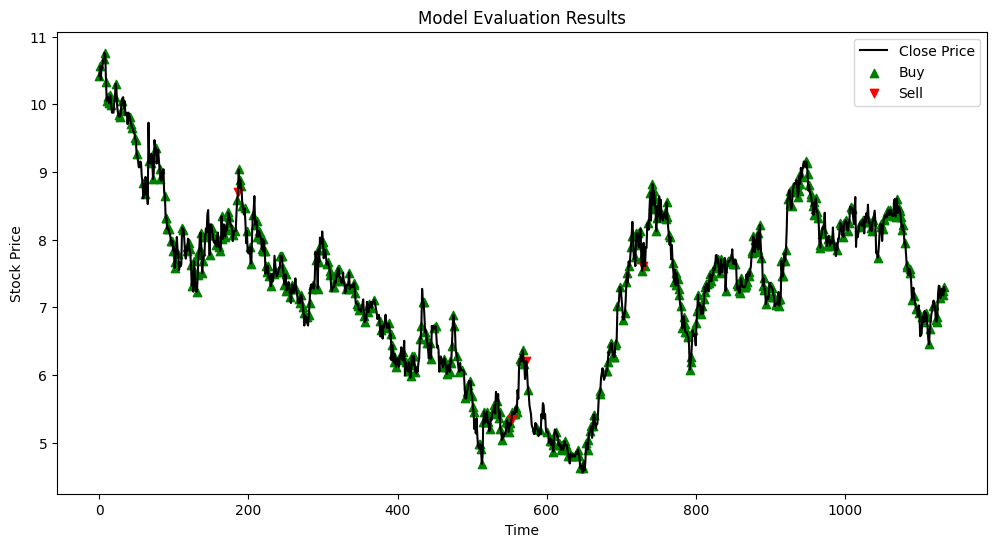

Action counts this episode: {}
Ticker: WMT | Episode 1/10 | Net PnL: 2532.10 | Wins: 1/1
Model progress saved.
Action counts this episode: {0: 72, 1: 61}
Ticker: WMT | Episode 2/10 | Net PnL: -964.46 | Wins: 1/2
Action counts this episode: {1: 162, 0: 95}
Ticker: WMT | Episode 3/10 | Net PnL: 907.83 | Wins: 2/3
Action counts this episode: {1: 318, 0: 88}
Ticker: WMT | Episode 4/10 | Net PnL: -291.14 | Wins: 2/4
Action counts this episode: {0: 559}
Ticker: WMT | Episode 5/10 | Net PnL: 3793.42 | Wins: 3/5
Action counts this episode: {0: 647, 1: 2}
Ticker: WMT | Episode 6/10 | Net PnL: 4239.02 | Wins: 4/6
Action counts this episode: {0: 794}
Ticker: WMT | Episode 7/10 | Net PnL: 5088.25 | Wins: 5/7
Action counts this episode: {0: 907, 2: 11}
Ticker: WMT | Episode 8/10 | Net PnL: 5551.24 | Wins: 6/8
Action counts this episode: {0: 924, 2: 121}
Ticker: WMT | Episode 9/10 | Net PnL: 577230.56 | Wins: 7/9
Action counts this episode: {0: 1121, 2: 93}
Ticker: WMT | Episode 10/10 | Net PnL: 623

<ipython-input-179-c90e7cfea695>:57: RuntimeWarning: overflow encountered in scalar add
  self.cash += shares_to_short * current_price - self.transaction_fee
<ipython-input-179-c90e7cfea695>:69: RuntimeWarning: overflow encountered in scalar multiply
  new_value = self.cash + (self.position - self.short_position) * price
<ipython-input-179-c90e7cfea695>:69: RuntimeWarning: invalid value encountered in scalar add
  new_value = self.cash + (self.position - self.short_position) * price
<ipython-input-179-c90e7cfea695>:69: RuntimeWarning: overflow encountered in scalar multiply
  new_value = self.cash + (self.position - self.short_position) * price
<ipython-input-179-c90e7cfea695>:69: RuntimeWarning: invalid value encountered in scalar add
  new_value = self.cash + (self.position - self.short_position) * price
<ipython-input-179-c90e7cfea695>:69: RuntimeWarning: overflow encountered in scalar multiply
  new_value = self.cash + (self.position - self.short_position) * price
<ipython-input-17

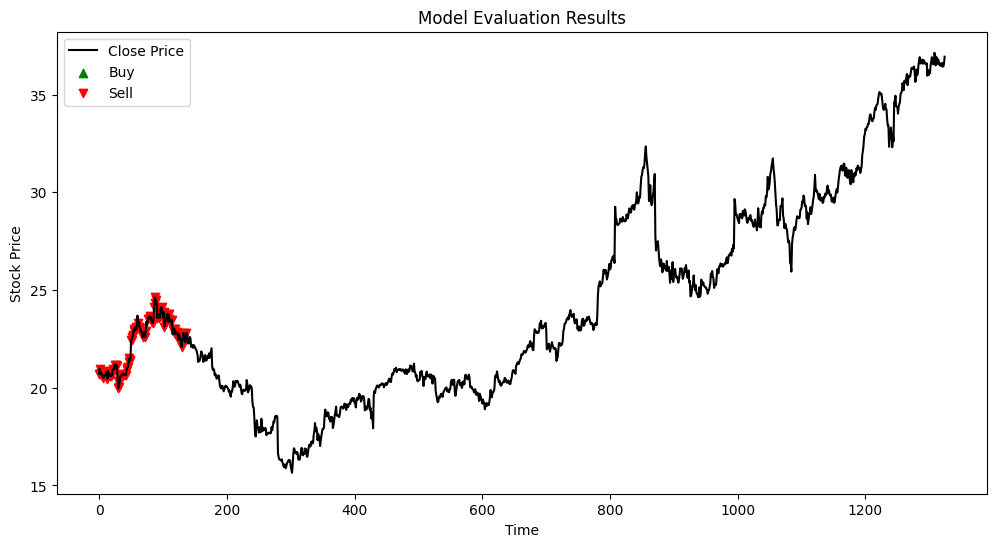

Action counts this episode: {}
Ticker: DGX | Episode 1/10 | Net PnL: 174.90 | Wins: 1/1
Model progress saved.
Action counts this episode: {0: 53, 2: 19}
Ticker: DGX | Episode 2/10 | Net PnL: -69434.62 | Wins: 1/2
Action counts this episode: {0: 62, 2: 63}
Ticker: DGX | Episode 3/10 | Net PnL: 380.97 | Wins: 2/3
Action counts this episode: {0: 114, 2: 125}
Ticker: DGX | Episode 4/10 | Net PnL: 1368.73 | Wins: 3/4
Action counts this episode: {0: 252, 1: 23, 2: 7}
Ticker: DGX | Episode 5/10 | Net PnL: 822.52 | Wins: 4/5
Action counts this episode: {0: 311, 1: 55}
Ticker: DGX | Episode 6/10 | Net PnL: 1249.12 | Wins: 5/6
Action counts this episode: {0: 410, 1: 17}
Ticker: DGX | Episode 7/10 | Net PnL: 1563.14 | Wins: 6/7
Action counts this episode: {0: 488, 2: 4, 1: 5}
Ticker: DGX | Episode 8/10 | Net PnL: 1491.51 | Wins: 7/8
Action counts this episode: {0: 507, 2: 66, 1: 1}
Ticker: DGX | Episode 9/10 | Net PnL: -7578.31 | Wins: 7/9
Action counts this episode: {0: 539, 2: 107}
Ticker: DGX 

<ipython-input-179-c90e7cfea695>:57: RuntimeWarning: overflow encountered in scalar add
  self.cash += shares_to_short * current_price - self.transaction_fee
<ipython-input-179-c90e7cfea695>:69: RuntimeWarning: overflow encountered in scalar multiply
  new_value = self.cash + (self.position - self.short_position) * price
<ipython-input-179-c90e7cfea695>:69: RuntimeWarning: invalid value encountered in scalar add
  new_value = self.cash + (self.position - self.short_position) * price
<ipython-input-179-c90e7cfea695>:56: RuntimeWarning: invalid value encountered in scalar floor_divide
  shares_to_short = self.cash // current_price


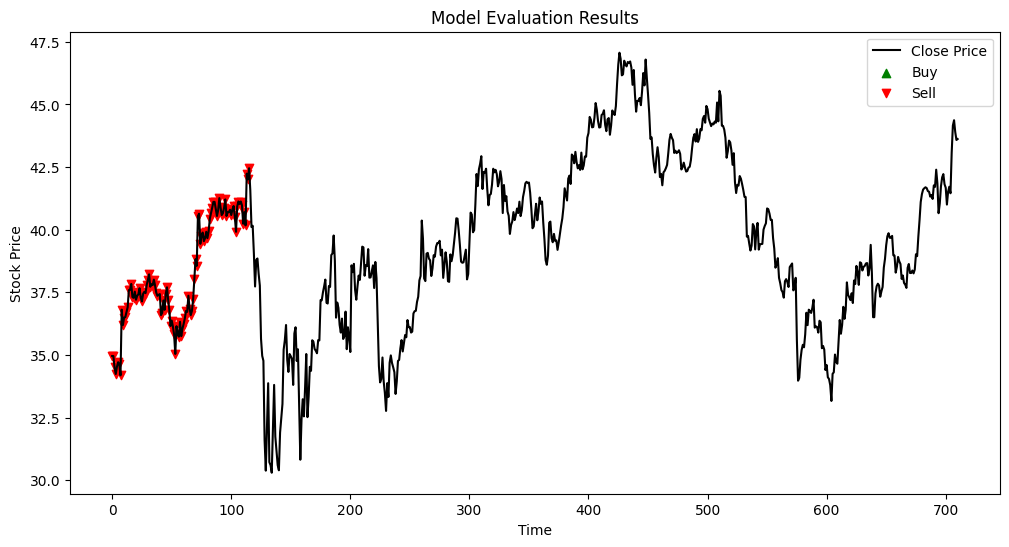

Action counts this episode: {}
Ticker: ROST | Episode 1/10 | Net PnL: -5002.20 | Wins: 0/1
Model progress saved.
Action counts this episode: {0: 105}
Ticker: ROST | Episode 2/10 | Net PnL: -3620.86 | Wins: 0/2
Action counts this episode: {0: 165, 2: 5, 1: 14}
Ticker: ROST | Episode 3/10 | Net PnL: 98.63 | Wins: 1/3
Action counts this episode: {0: 228, 2: 69}
Ticker: ROST | Episode 4/10 | Net PnL: -19398.94 | Wins: 1/4
Action counts this episode: {0: 406}
Ticker: ROST | Episode 5/10 | Net PnL: -3064.20 | Wins: 1/5
Action counts this episode: {0: 451}
Ticker: ROST | Episode 6/10 | Net PnL: -2781.22 | Wins: 1/6
Action counts this episode: {0: 603}
Ticker: ROST | Episode 7/10 | Net PnL: -1110.04 | Wins: 1/7
Action counts this episode: {0: 675, 1: 28}
Ticker: ROST | Episode 8/10 | Net PnL: -2163.13 | Wins: 1/8
Action counts this episode: {0: 788, 1: 1}
Ticker: ROST | Episode 9/10 | Net PnL: -258.63 | Wins: 1/9
Action counts this episode: {0: 905}
Ticker: ROST | Episode 10/10 | Net PnL: 315.

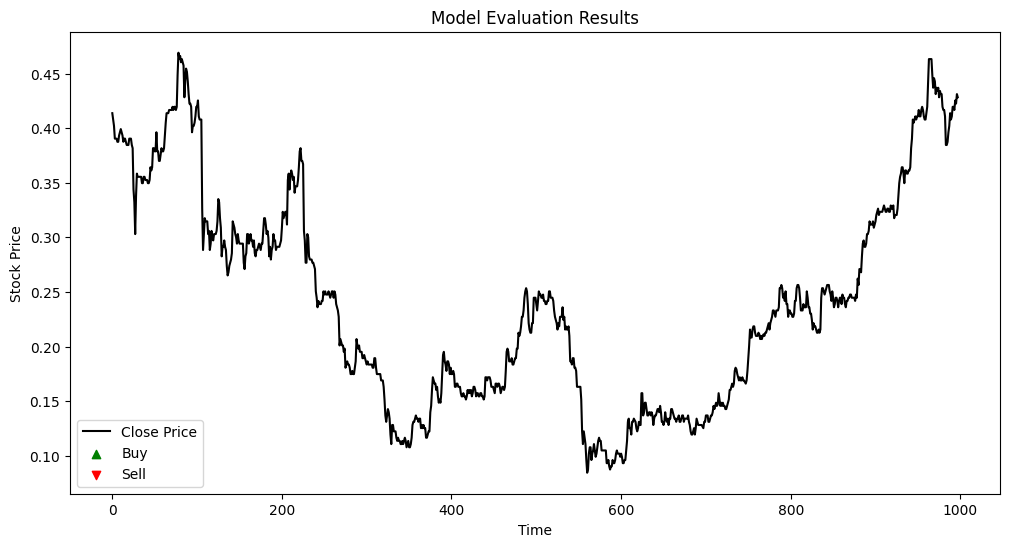

Action counts this episode: {}
Ticker: DTE | Episode 1/10 | Net PnL: -4204.76 | Wins: 0/1
Model progress saved.
Action counts this episode: {0: 161}
Ticker: DTE | Episode 2/10 | Net PnL: -3592.07 | Wins: 0/2
Action counts this episode: {0: 285}
Ticker: DTE | Episode 3/10 | Net PnL: -3390.74 | Wins: 0/3
Action counts this episode: {0: 478}
Ticker: DTE | Episode 4/10 | Net PnL: -2913.89 | Wins: 0/4
Action counts this episode: {0: 623}
Ticker: DTE | Episode 5/10 | Net PnL: -2431.53 | Wins: 0/5
Action counts this episode: {0: 774}
Ticker: DTE | Episode 6/10 | Net PnL: -5506.57 | Wins: 0/6
Action counts this episode: {0: 931}
Ticker: DTE | Episode 7/10 | Net PnL: -1604.10 | Wins: 0/7
Action counts this episode: {0: 1108}
Ticker: DTE | Episode 8/10 | Net PnL: -777.48 | Wins: 0/8
Action counts this episode: {0: 1293}
Ticker: DTE | Episode 9/10 | Net PnL: 837.39 | Wins: 1/9
Action counts this episode: {0: 1433}
Ticker: DTE | Episode 10/10 | Net PnL: 147.71 | Wins: 2/10


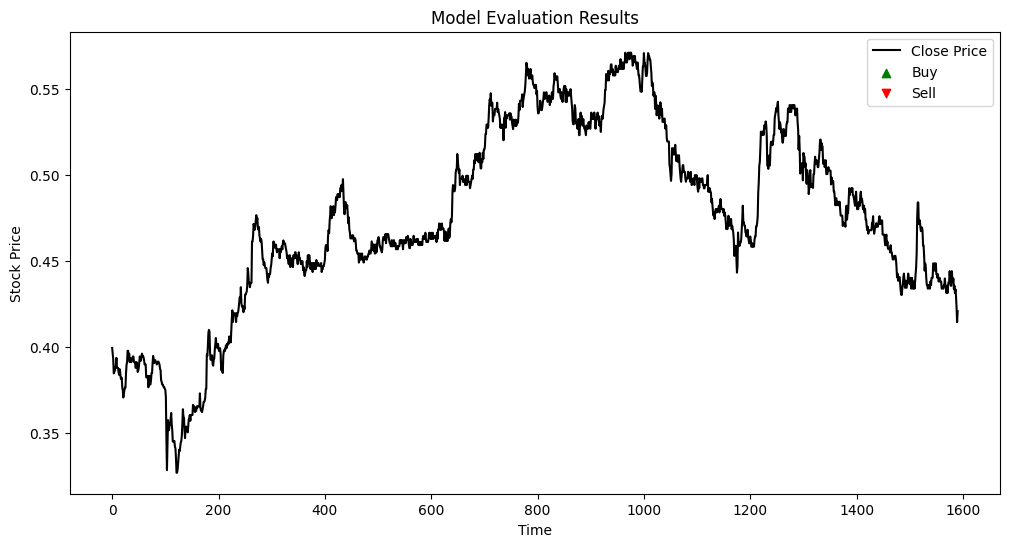

Action counts this episode: {}
Ticker: ABT | Episode 1/10 | Net PnL: 11266.75 | Wins: 1/1
Model progress saved.
Action counts this episode: {0: 48, 2: 69}
Ticker: ABT | Episode 2/10 | Net PnL: 14432.72 | Wins: 2/2
Action counts this episode: {0: 197, 2: 32}
Ticker: ABT | Episode 3/10 | Net PnL: 12338.30 | Wins: 3/3
Action counts this episode: {0: 306, 2: 35}
Ticker: ABT | Episode 4/10 | Net PnL: 14207.45 | Wins: 4/4
Action counts this episode: {0: 117, 2: 340}
Ticker: ABT | Episode 5/10 | Net PnL: -106117.30 | Wins: 4/5
Action counts this episode: {2: 277, 0: 311, 1: 13}
Ticker: ABT | Episode 6/10 | Net PnL: -782839.19 | Wins: 4/6
Action counts this episode: {0: 386, 1: 297}
Ticker: ABT | Episode 7/10 | Net PnL: -3376.10 | Wins: 4/7
Action counts this episode: {1: 476, 0: 313}
Ticker: ABT | Episode 8/10 | Net PnL: 10959.01 | Wins: 5/8
Action counts this episode: {0: 141, 1: 751}
Ticker: ABT | Episode 9/10 | Net PnL: 10354.24 | Wins: 6/9
Action counts this episode: {0: 703, 1: 311}
Tick

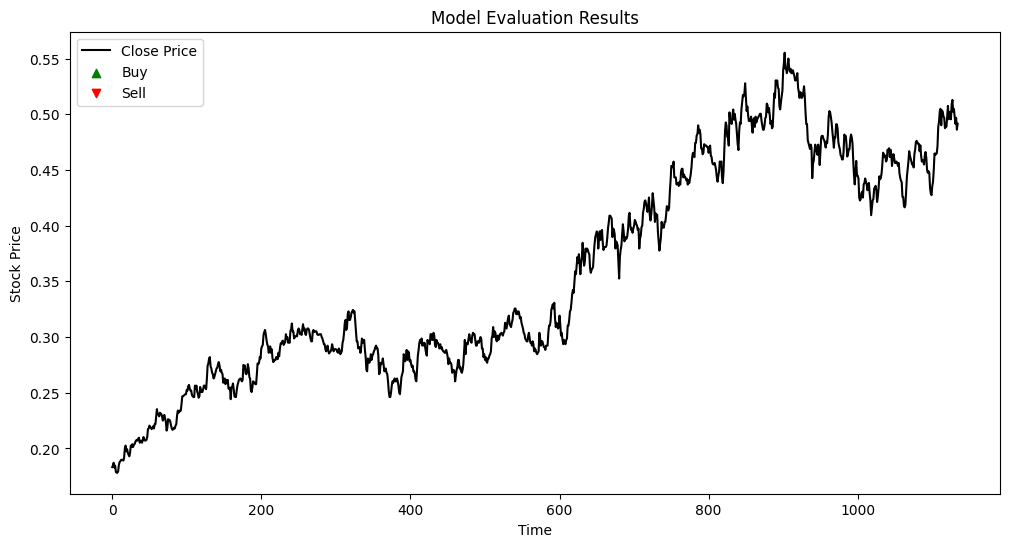

Action counts this episode: {}
Ticker: UNP | Episode 1/10 | Net PnL: -2754.00 | Wins: 0/1
Model progress saved.
Action counts this episode: {0: 134, 1: 5}
Ticker: UNP | Episode 2/10 | Net PnL: -2930.83 | Wins: 0/2
Action counts this episode: {0: 218, 1: 7}
Ticker: UNP | Episode 3/10 | Net PnL: -1791.10 | Wins: 0/3
Action counts this episode: {1: 24, 0: 318}
Ticker: UNP | Episode 4/10 | Net PnL: -2828.31 | Wins: 0/4
Action counts this episode: {0: 462, 1: 2}
Ticker: UNP | Episode 5/10 | Net PnL: -2236.20 | Wins: 0/5
Action counts this episode: {0: 497, 1: 63}
Ticker: UNP | Episode 6/10 | Net PnL: -1450.80 | Wins: 0/6
Action counts this episode: {0: 703}
Ticker: UNP | Episode 7/10 | Net PnL: -662.69 | Wins: 0/7
Action counts this episode: {0: 809}
Ticker: UNP | Episode 8/10 | Net PnL: 140386.50 | Wins: 1/8
Action counts this episode: {0: 917}
Ticker: UNP | Episode 9/10 | Net PnL: -186.61 | Wins: 1/9
Action counts this episode: {0: 1043}
Ticker: UNP | Episode 10/10 | Net PnL: -160.65 | Wi

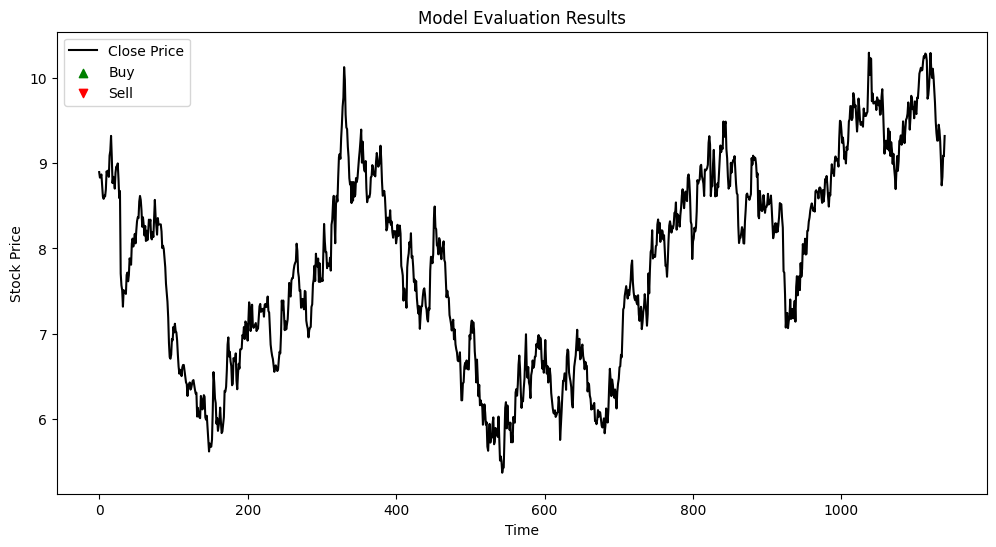

Action counts this episode: {}
Ticker: LYB | Episode 1/10 | Net PnL: -2695.58 | Wins: 0/1
Model progress saved.
Action counts this episode: {0: 46}
Ticker: LYB | Episode 2/10 | Net PnL: -2535.40 | Wins: 0/2
Action counts this episode: {0: 78}
Ticker: LYB | Episode 3/10 | Net PnL: -2456.55 | Wins: 0/3
Action counts this episode: {0: 104}
Ticker: LYB | Episode 4/10 | Net PnL: -2542.01 | Wins: 0/4
Action counts this episode: {0: 138, 2: 11}
Ticker: LYB | Episode 5/10 | Net PnL: -2207.37 | Wins: 0/5
Action counts this episode: {2: 27, 0: 157}
Ticker: LYB | Episode 6/10 | Net PnL: -2196.94 | Wins: 0/6
Action counts this episode: {0: 209, 2: 24}
Ticker: LYB | Episode 7/10 | Net PnL: -878.48 | Wins: 0/7
Action counts this episode: {0: 265, 2: 4}
Ticker: LYB | Episode 8/10 | Net PnL: -2191.61 | Wins: 0/8
Action counts this episode: {0: 229, 2: 83}
Ticker: LYB | Episode 9/10 | Net PnL: -628935950336.00 | Wins: 0/9
Action counts this episode: {0: 339, 2: 1}
Ticker: LYB | Episode 10/10 | Net PnL:

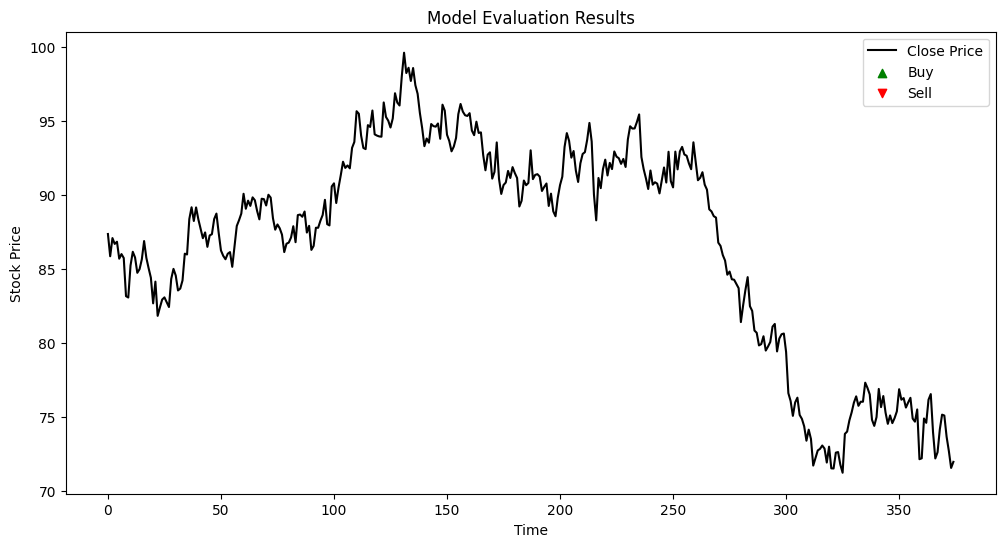

Action counts this episode: {}
Ticker: AJG | Episode 1/10 | Net PnL: -2117.60 | Wins: 0/1
Model progress saved.
Action counts this episode: {0: 108}
Ticker: AJG | Episode 2/10 | Net PnL: -2651.79 | Wins: 0/2
Action counts this episode: {0: 219}
Ticker: AJG | Episode 3/10 | Net PnL: -2169.94 | Wins: 0/3
Action counts this episode: {0: 297}
Ticker: AJG | Episode 4/10 | Net PnL: -2713.57 | Wins: 0/4
Action counts this episode: {0: 362}
Ticker: AJG | Episode 5/10 | Net PnL: -242.85 | Wins: 0/5
Action counts this episode: {0: 511}
Ticker: AJG | Episode 6/10 | Net PnL: -367.18 | Wins: 0/6
Action counts this episode: {0: 633}
Ticker: AJG | Episode 7/10 | Net PnL: -13.83 | Wins: 0/7
Action counts this episode: {0: 738}
Ticker: AJG | Episode 8/10 | Net PnL: 4362.77 | Wins: 1/8
Action counts this episode: {0: 697, 1: 160}
Ticker: AJG | Episode 9/10 | Net PnL: -2097.46 | Wins: 1/9
Action counts this episode: {0: 899, 1: 41}
Ticker: AJG | Episode 10/10 | Net PnL: 851.67 | Wins: 2/10


KeyboardInterrupt: 

In [185]:

# Run training
train_on_sp500(dataset, episodes=10)
